# Model a _Normal_ distribution
This is equivalent to a linear model without predictors: $y\sim\mathcal{N}(\mu, \sigma)$

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## Generate artificial data

In [22]:
mu_real = 0
sd_real = 1

n_samples = 150

In [23]:
# Random seed need to be in the same cell.
np.random.seed(SEED)

Y = np.random.normal(loc=mu_real, scale=sd_real, size=n_samples)

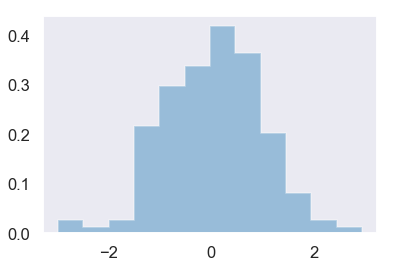

In [24]:
sns.distplot(Y, norm_hist=True, kde=False, hist_kws={'histtype':'stepfilled'});

In [39]:
print(f'Mean = {np.mean(Y).round(2)} \t Std = {np.std(Y).round(2)}')

Mean = 0.02 	 Std = 0.99


## Bayesian modelling

In [25]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [26]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=0, sd=50)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=Y)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2140' (I am process '1968')


In [27]:
model.check_test_point()

mu             -4.83
sd_log__       -0.77
likelihood   -690.82
Name: Log-probability of test_point, dtype: float64

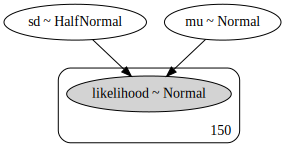

In [28]:
pm.model_to_graphviz(model)

### Sample from the model

In [29]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████████████████████████████████| 12000/12000 [00:09<00:00, 1216.54draws/s]


### Diagnose the sampling

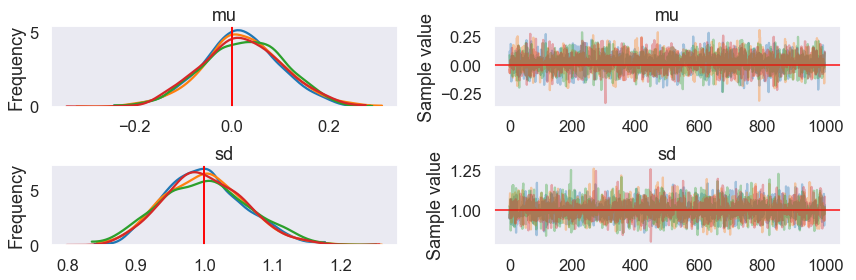

In [30]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

### Summarize the posterior density

In [31]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.02,0.08,0.0,-0.14,0.18,4172.22,1.0
sd,1.00,0.06,0.0,0.89,1.12,4023.63,1.0


### Posterior predictive check

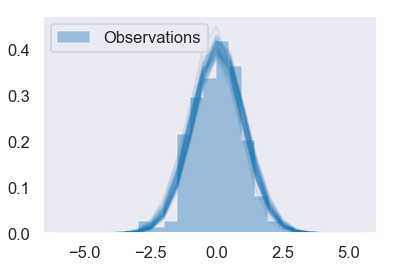

In [36]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(-6, 6, 0.5)

sns.distplot(Y, norm_hist=True, kde=False, label='Observations', hist_kws={'histtype':'stepfilled'})

for mu, sd in zip(trace['mu'][::THIN], trace['sd'][::THIN]):
    ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[0])

plt.legend();

## Statistical inference

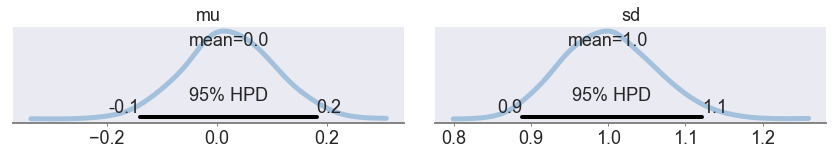

In [42]:
pm.plot_posterior(trace, varnames=['mu', 'sd'], round_to=1, kde_plot=True, lw=5);